# Binary Cancer Detection Prediction

In this project I will build a classifier that takes in images and provides a predition if  there is " metastatic cancer in small image patches taken from larger digital pathology scans." or not. 

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from PIL import Image


## EDA

In [2]:
# Read files in 
training_data = '/kaggle/input/histopathologic-cancer-detection/train'
test_data = '/kaggle/input/histopathologic-cancer-detection/test'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [3]:
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


200k images seems like a lot! 

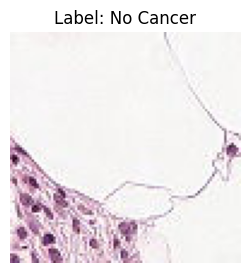

In [4]:
# Take a look at some images

plt.figure(figsize=(5, 3))

img_path = os.path.join(training_data,'f38a6374c348f90b587e046aac6079959adf3835' + '.tif')
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Label: No Cancer")
plt.axis('off')
plt.show()



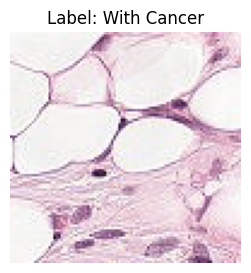

In [5]:
# Image With Cancer

plt.figure(figsize=(5, 3))

img_path = os.path.join(training_data,'d4b854fe38b07fe2831ad73892b3cec877689576' + '.tif')
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Label: With Cancer")
plt.axis('off')
plt.show()

Pretty hard to tell a difference.

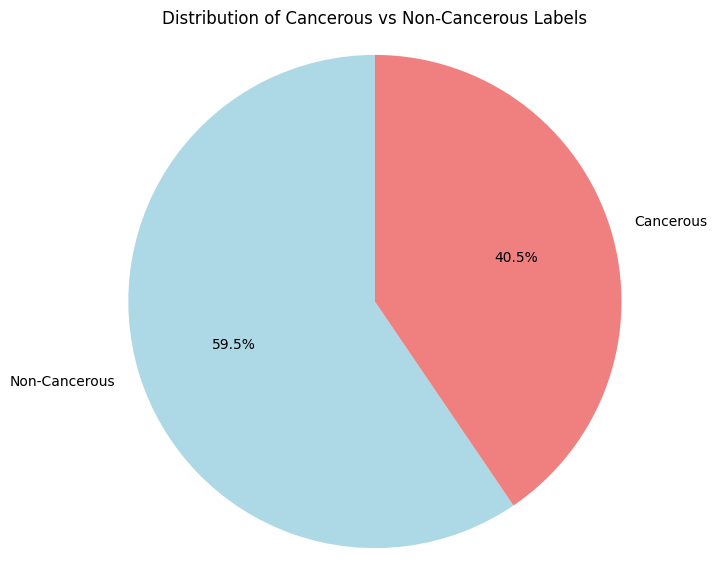

In [6]:
# Prevelence of label
label_counts = train_labels['label'].value_counts()

labels = ['Non-Cancerous', 'Cancerous']
sizes = [label_counts[0], label_counts[1]] 
colors = ['lightblue', 'lightcoral']


plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal') 


plt.title('Distribution of Cancerous vs Non-Cancerous Labels')


plt.show()

Not too much of a class imbalance, so thats pretty nice.

## Pre Process images

In [7]:
def pre_process_training(csv_file, root_dir, batch_size=32, img_size=(60, 60), shuffle=True):
    annotations = csv_file
    indexes = np.arange(len(annotations))
    
    while True: 
        if shuffle:
            np.random.shuffle(indexes)

        for start in range(0, len(annotations), batch_size):
            end = min(start + batch_size, len(annotations))
            batch_indexes = indexes[start:end]
            batch_annotations = annotations.iloc[batch_indexes]

            images = np.empty((len(batch_indexes), *img_size, 3)) 
            labels = np.empty((len(batch_indexes)), dtype=int)

            for i, (_, row) in enumerate(batch_annotations.iterrows()):
                img_name = os.path.join(root_dir, row[0] + '.tif')
                image = Image.open(img_name)
                image = image.resize(img_size)  
                image = np.array(image) / 255.0  

                images[i] = image
                labels[i] = int(row[1])

            yield images, labels


    
# training data      
train_data_generator = pre_process_training(
    csv_file=train_labels, 
    root_dir=training_data,
    batch_size=256,
    img_size=(60, 60)
)

images, labels = next(train_data_generator)
print(images.shape, labels.shape)

/tmp/ipykernel_30/2416656145.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = os.path.join(root_dir, row[0] + '.tif')
/tmp/ipykernel_30/2416656145.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels[i] = int(row[1])


(256, 60, 60, 3) (256,)


## Simple CNN

Model Architecture:
- Convolutional Layer 1: Conv2D with relu activation, 16 filters of size 3x3
- Pooling Layer 1: Max Pooling
- Convolutional Layer 2: Conv2D with relu activation, 32 filters of size 3x3
- Pooling Layer 2: Max Pooling
- Flatening layer
- Dense layber
- Output layer

In [ ]:
def create_simple_cnn(input_shape):
    model = models.Sequential()
    
    #conv layer 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # conv layer 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Fully Connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  

    return model

Model summary
input_shape = (60, 60, 3)
model = create_simple_cnn(input_shape)
model.summary()


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

steps_per_epoch = len(train_labels) // 256


simple_cnn = model.fit(
    train_data_generator,
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)


model.save('simple_cnn_model.h5')

Results from simple CNN:


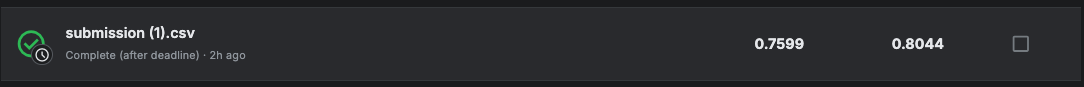

# Run simple CNN on test data 

In [ ]:
def test_data_generator(root_dir, img_size=(60, 60), batch_size=32):
    image_files = os.listdir(root_dir)
    
    while True:
        for start in range(0, len(image_files), batch_size):
            images = np.empty((batch_size, *img_size, 3))  # Assuming RGB images
            
            for i in range(batch_size):
                img_name = os.path.join(root_dir, image_files[start + i])
                image = Image.open(img_name)
                image = image.resize(img_size) 
                image = np.array(image) / 255.0  
                
                images[i] = image
            
            yield (images,)  # Yield a tuple with the inpute

In [ ]:


test_gen = test_data_generator(test_data, img_size=(60, 60), batch_size=1)

num_test_images = len(os.listdir(test_data))

# Make predictions
predictions_simple_cnn = model.predict(test_gen, steps=num_test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions_simple_cnn, axis=1)  # Get class indices


print(predicted_classes)


submission_df = pd.DataFrame({
    'id': os.listdir(test_data), 
    'label': predicted_classes
})
# remove .tif from the id column
submission_df['id'] = submission_df['id'].apply(lambda x: x.split('.')[0]) 
submission_df.to_csv('submission.csv', index=False)

## Complex CNN

- Convolutional Layer 1:
    Conv2D with ReLU activation, 32 filters of size 3x3
    Followed by Batch Normalization
    
- Convolutional Layer 2:
    Conv2D with ReLU activation, 32 filters of size 3x3
    Followed by Batch Normalization
    
- Pooling Layer 1:
    Max Pooling with a pool size of 2x2
    Dropout with a rate of 25%
    
- Convolutional Layer 3:
    Conv2D with ReLU activation, 64 filters of size 3x3
    Followed by Batch Normalization
    
- Convolutional Layer 4:
    Conv2D with ReLU activation, 64 filters of size 3x3
    Followed by Batch Normalization
    
- Pooling Layer 2:
    Max Pooling with a pool size of 2x2
    Dropout with a rate of 25%
    
- Convolutional Layer 5:
    Conv2D with ReLU activation, 128 filters of size 3x3
    Followed by Batch Normalization
    
- Convolutional Layer 6:
    Conv2D with ReLU activation, 128 filters of size 3x3
    Followed by Batch Normalization
    
- Pooling Layer 3:
    Max Pooling with a pool size of 2x2
    Dropout with a rate of 25%
    
- Flattening Layer:
    Flattens the 3D output of the convolutional layers into a 1D vector.
    
- Dense Layer 1:
    Fully connected layer with 256 units, ReLU activation
    Followed by Batch Normalization and Dropout with a rate of 50%
    
- Dense Layer 2:
    Fully connected layer with 128 units, ReLU activation
    Followed by Batch Normalization and Dropout with a rate of 50%
    
- Output Layer:
    Dense layer with 2 units (for binary classification)
    Softmax activation

In [ ]:
def create_complex_cnn(input_shape):
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and Fully Connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification

    return model


input_shape = (60, 60, 3)

# Create and compile the complex model
complex_model = create_complex_cnn(input_shape)
complex_model.summary()


complex_model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
steps_per_epoch = len(train_labels) // 256

# Train the complex model
complex_cnn_history = complex_model.fit(
    train_data_generator,
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)

# Save the model
complex_model.save('complex_cnn_model.h5')

In [ ]:
test_gen = test_data_generator(test_data, img_size=(60, 60), batch_size=1)

num_test_images = len(os.listdir(test_data))

# Make predictions
predictions_complex_cnn = complex_model.predict(test_gen, steps=num_test_images)

# Convert predictions to class labels
predicted_classes_complex = np.argmax(predictions_complex_cnn, axis=1)  


submission_df = pd.DataFrame({
    'id': os.listdir(test_data), 
    'label': predicted_classes_complex
})
 # remove .tif from the id
submission_df['id'] = submission_df['id'].apply(lambda x: x.split('.')[0])

submission_df.to_csv('submission.csv', index=False)

Results with 3 epochs:

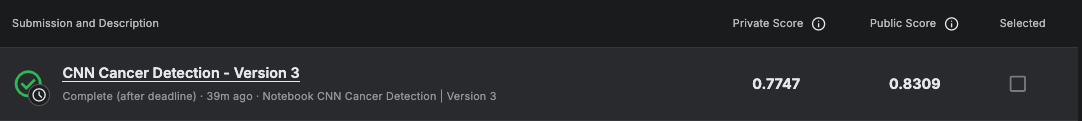